### Discrete regression

In [1]:
import sys
sys.path.append('../../Utilities/src')

from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import pandas as pd


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [3]:
from DA_tools.DA_tools import ribbon_plot
from DA_tools.DA_colors import *


In [4]:
def integer_histogram_matrix(max_y,y_ppc):
    if len(y_ppc.shape)==1:
        y_ppc=np.expand_dims(y_ppc,axis=0)
    B=max_y+1
    bins = np.array([*range(B+1)])-0.5
    counts = [np.histogram(y_ppc[n], bins=bins)[0] for n in range(y_ppc.shape[0])]
    return bins, np.array(counts)

def pad_hist_for_plot(bins,counts):
    if len(counts.shape)==1:
        ax=0
    else: ax=1
        
    xs = (np.repeat(bins,repeats=2))[1:-1]
    pad_counts = np.repeat(counts,repeats=2,axis=ax)
    return xs, pad_counts

In [5]:
df = pd.read_csv('discrete_regression_data.csv',index_col=0)

In [6]:
df.describe()

,x_1,x_2,x_3,y
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.001349,0.328014,-0.008712,8.640000
std,0.573010,0.294522,0.369813,4.115256
min,-0.997592,0.000008,-0.992794,0.000000
25%,-0.501613,0.054107,-0.126214,6.000000
50%,-0.012899,0.251657,-0.000002,8.000000
75%,0.501155,0.547333,0.125869,11.000000
max,0.999151,0.998302,0.997455,28.000000


### Prior predictive checks

In [7]:
with open('poisson_ppc.stan', 'r') as file:
    print(file.read())
model_ppc = CmdStanModel(stan_file='poisson_ppc.stan')


INFO:cmdstanpy:compiling stan program, exe file: /var/folders/j5/wr2j95x534x62nm4sfx97cbc0000gn/T/tmponcfurtb/tmp9xb31j04
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
data {
  int<lower=0> M; // Number of covariates
  int<lower=0> N; // Number of observations
  matrix[N, M] X; // Covariate design matrix
  real<lower=0> sigma;      // prior_standard_deviation
}

transformed data {
  vector[N] ones_N = rep_vector(1, N);
  vector[M] ones_M = rep_vector(1, M);
}

// Simulate a full observation from the current value of the parameters
generated quantities {
  real  beta[M] = normal_rng(ones_M * 0,ones_M * sigma);  // Slopes
  real alpha = normal_rng(0,sigma);      // Intercept
  vector[N] lambda = X * to_vector(beta) + ones_N * alpha;
  int y_ppc[N] = poisson_log_rng(lambda);
}

INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 7 - Generalized linear models/Dispersed poisson regresion/poisson_ppc


In [20]:
data_ppc = dict(M=3, N=1000,X=df.loc[:,'x_1':'x_3'].values,sigma=10)


R = 1000
sim_ppc=model_ppc.sample(data=data_ppc, 
                           iter_sampling=R, iter_warmup=0, 
                           chains=1, 
                           refresh=R,
                           fixed_param=True,
                           seed=29042020,
                           output_dir='samples')

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [10]:
sim_ppc.diagnose()

INFO:cmdstanpy:Processing csv files: /var/folders/j5/wr2j95x534x62nm4sfx97cbc0000gn/T/tmpiecmj9b_/poisson_ppc-202105012008-1-hmk1egrv.csvWarning: non-fatal error reading adaptation data


Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


'Processing csv files: /var/folders/j5/wr2j95x534x62nm4sfx97cbc0000gn/T/tmpiecmj9b_/poisson_ppc-202105012008-1-hmk1egrv.csvWarning: non-fatal error reading adaptation data\n\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.'

#### Exception warning
Setting too high $\sigma$ in priors results in following exceptions (see stdout.txt file)

```
Exception: poisson_log_rng: Log rate parameter[1] is 22.5551, but must be less than 20.7944  (in 'unknown file name' at line 17)

Exception: poisson_log_rng: Log rate parameter[13] is 22.6184, but must be less than 20.7944  (in 'unknown file name' at line 17)

Exception: poisson_log_rng: Log rate parameter[1] is 27.0051, but must be less than 20.7944  (in 'unknown file name' at line 17)

Exception: poisson_log_rng: Log rate parameter[16] is 25.1868, but must be less than 20.7944  (in 'unknown file name' at line 17)

Exception: poisson_log_rng: Log rate parameter[9] is 25.1681, but must be less than 20.7944  (in 'unknown file name' at line 17)

Exception: poisson_log_rng: Log rate parameter[8] is 26.3585, but must be less than 20.7944  (in 'unknown file name' at line 17)

Exception: poisson_log_rng: Log rate parameter[2] is 21.3792, but must be less than 20.7944  (in 'unknown file name' at line 17)

Exception: poisson_log_rng: Log rate parameter[13] is 23.3107, but must be less than 20.7944  (in 'unknown file name' at line 17)

Exception: poisson_log_rng: Log rate parameter[9] is 27.6798, but must be less than 20.7944  (in 'unknown file name' at line 17)

Exception: poisson_log_rng: Log rate parameter[9] is 22.5301, but must be less than 20.7944  (in 'unknown file name' at line 17)
```

#### What is going on?

```poisson_log_rng ``` and consequently ```poison_log``` are operating as Poisson distribution in the form
$$
y\sim\mathrm{Poisson}(\exp(\theta))
$$
where $\theta$ is the parametr of interest. And what is the interpretation of this parameter value of ```20.7944```? It is the rate of Poisson distribution:


In [13]:
lam = np.exp(20.7944)
print(lam)

1073725270.4664105


But this is just a number, however lets take its base 2 logarithm

In [14]:
np.log2(lam)

29.99997775826146

This is almost 30, and $2^{30}$ is a limit of ```int32``` capacity. 

#### Prior tuning
Setting $\sigma=10$ would be fine on linear scale, but in GLMs we generally need to be careful. 
If we choose $\sigma=2$ having predictors bounded to $[-1,1]$ it still has a possibility to cover relatively very large numbers if needed, but without warnings. 


Our data was limited to 28, but to stay on the safe side let us limit our priors to keep us under few thousand. For $\sigma=2$ there is around 1% probability (assuming all predictors at maximum), that 
$$ X\beta+\alpha > 8 $$

And this corresponds to $\lambda$

In [15]:
lam_ub=np.exp(8)
print('Lambda upper bound: {0:4.2f}'.format(lam_ub))

Lambda upper bound: 2980.96


Using familiar formula, we have $y_\mathrm{bound}$ of  to be 
$$ \lambda +3\sqrt{\lambda}=y_\mathrm{bound}$$

In [17]:
y_bound=int(lam_ub+3*np.sqrt(lam_ub))
print('Upper value of y:{}'.format(y_bound))




Upper value of y:3144


### Prior predictions

In [18]:
data_ppc = dict(M=3, N=1000,X=df.loc[:,'x_1':'x_3'].values,sigma=2)


R = 1000
sim_ppc=model_ppc.sample(data=data_ppc, 
                           iter_sampling=R, iter_warmup=0, 
                           chains=1, 
                           refresh=R,
                           fixed_param=True,
                           seed=29042020,
                           output_dir='samples/sigma2')

pars_mat=np.concatenate((sim_ppc.stan_variable('beta'),np.expand_dims(sim_ppc.stan_variable('alpha'),axis=1)),axis=1)

INFO:cmdstanpy:created output directory: /Users/jerzybaranowski/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 7 - Generalized linear models/Dispersed poisson regresion/samples/sigma2
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


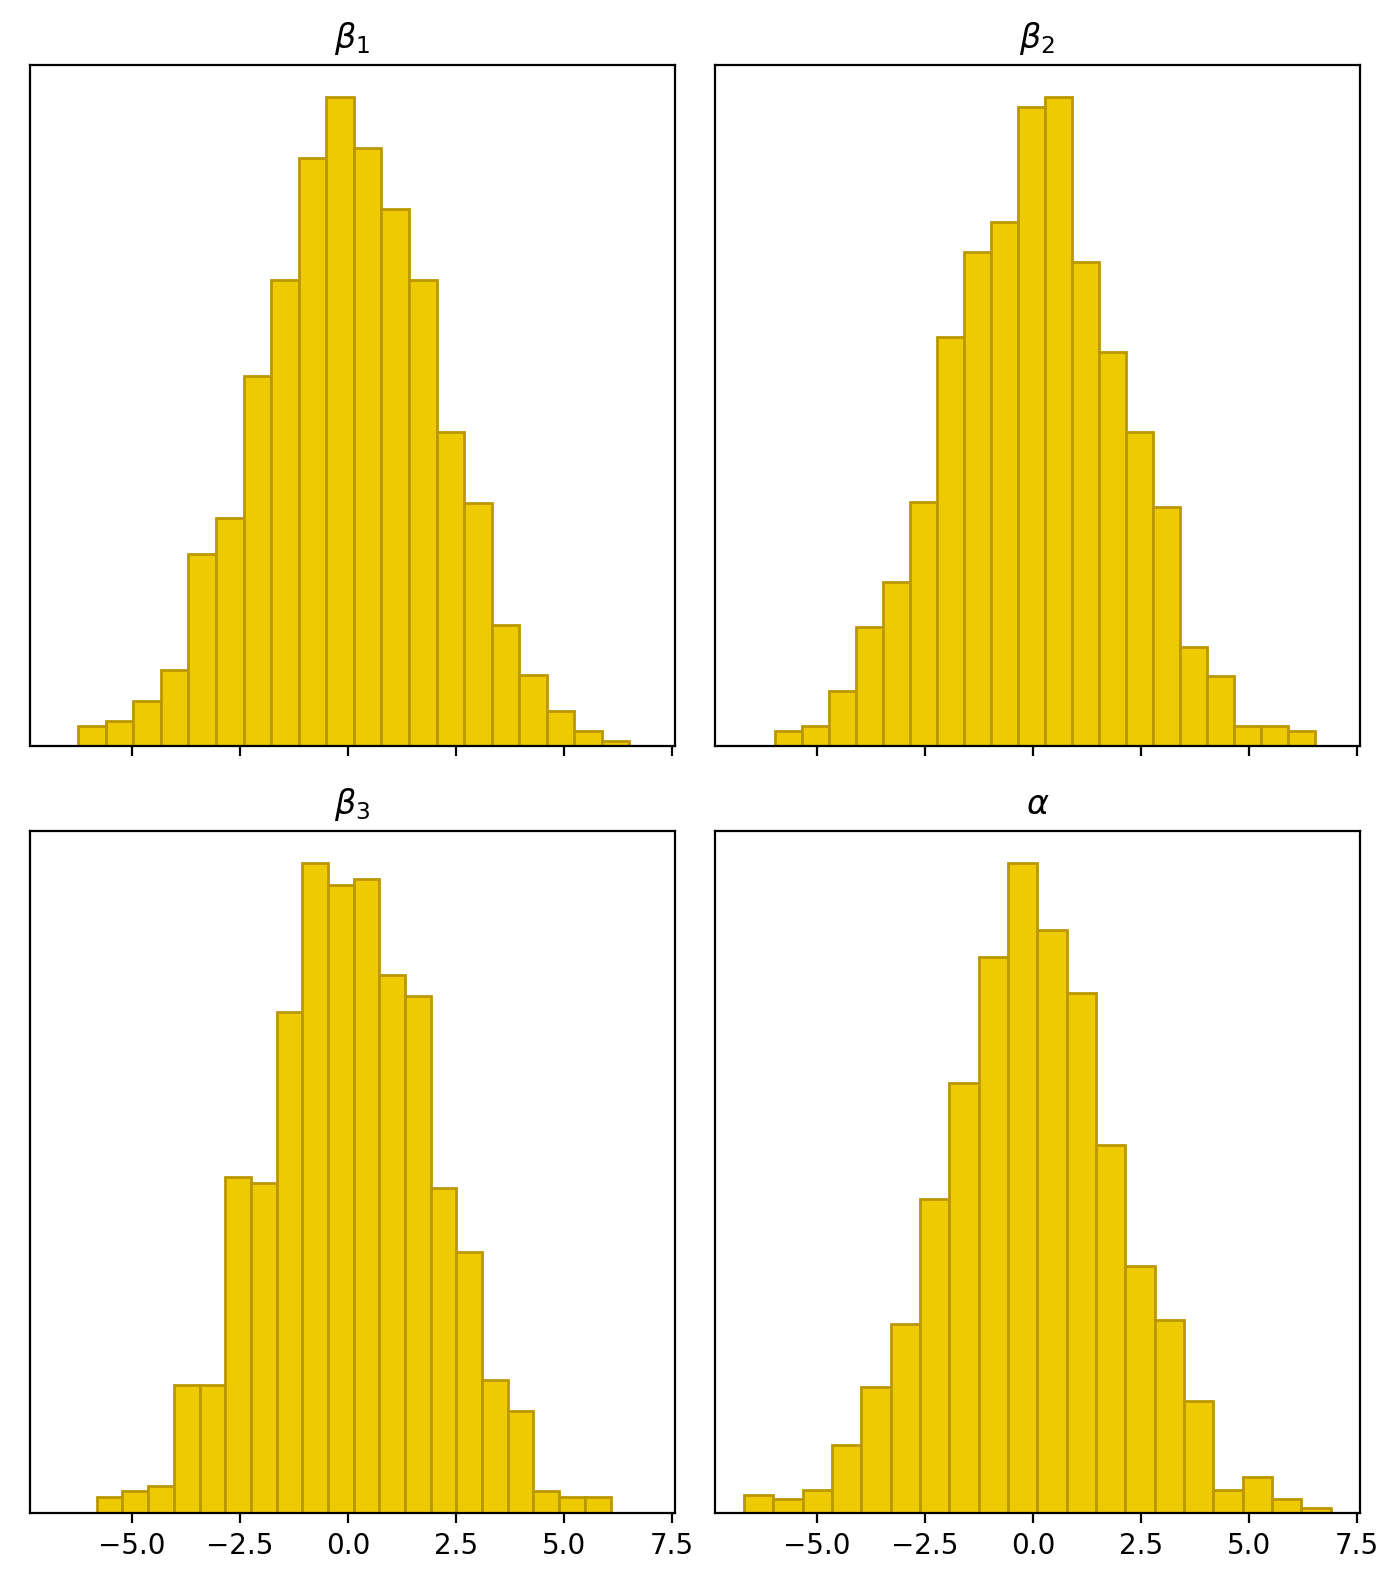

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(7, 8), squeeze=False,sharex=True)
axes_flat=axes.flatten()
names_of_pars = [r'$\beta_1$',r'$\beta_2$',r'$\beta_3$',r'$\alpha$',r'$\phi$',r'$\psi=\phi^{-1}$']
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(pars_mat[:,k],bins=20,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
    ax.set_title(names_of_pars[k])
    ax.set_yticks([])
fig.tight_layout()

plt.show()

In [30]:
np.max(sim_ppc.stan_variable('lambda')[0])

4.68059

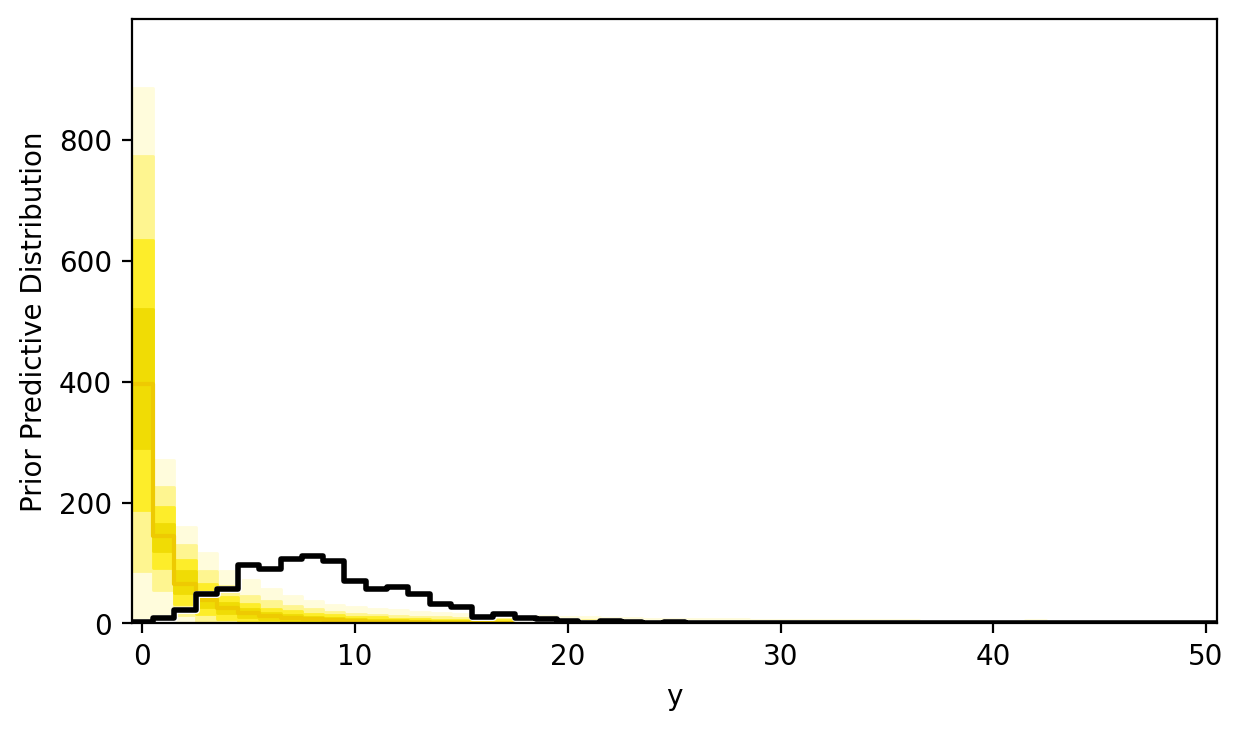

In [32]:
y_ppc = (sim_ppc.stan_variable('y_ppc'))
max_y = 50

bins,counts = integer_histogram_matrix(max_y,y_ppc)
xs, pad_counts = pad_hist_for_plot(bins,counts)    
obs_counts = np.histogram(df['y'], bins=bins)[0]
_, pad_obs_counts = pad_hist_for_plot(bins,obs_counts)


fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax=ribbon_plot(xs,pad_counts,ax,supress_warning=True)

ax.plot(xs, pad_obs_counts, linewidth=2.5, color="white",zorder=1)
ax.plot(xs, pad_obs_counts, linewidth=2.0, color="black",zorder=2)
ax.set_xlim([min(bins), max(bins)])
ax.set_xlabel("y")
ax.set_ylim([0, max(max(obs_counts), np.max(counts))])
ax.set_ylabel("Prior Predictive Distribution")

plt.show()

### Posterior inference and prediction

In [34]:
model = CmdStanModel(stan_file='poisson2.stan')
with open('poisson2.stan', 'r') as file:
    print(file.read())

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/j5/wr2j95x534x62nm4sfx97cbc0000gn/T/tmpj54o58f2/tmpk7b2h_0o
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 7 - Generalized linear models/Dispersed poisson regresion/poisson2
data {
  int<lower=0> M; // Number of covariates
  int<lower=0> N; // Number of observations
  matrix[N, M] X; // Covariate design matrix
  int y[N];      // Variates
}

transformed data {
  vector[N] ones_N = rep_vector(1, N);
}

parameters {
  vector[M] beta;  // Slopes
  real alpha;      // Intercept
}

model {
  // Prior model
  beta ~ normal(0, 2);
  alpha ~ normal(0, 2);

  // Observational model

  // poisson_log automatically exponentiates the input
  // poisson_log(X * beta + alpha) = poisson(exp(X * beta + alpha))
  y ~ poisson_log(X * beta + alpha);
}

// Simulate a full observation from the current value of th

In [37]:
data = dict(M=3, N=1000,X=df.loc[:,'x_1':'x_3'].values,y=df.y.values)

fit = model.sample(data=data, seed=12062020)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2


In [38]:
pars_mat_1=np.concatenate((fit.stan_variable('beta'),np.expand_dims(fit.stan_variable('alpha'),axis=1)),axis=1)

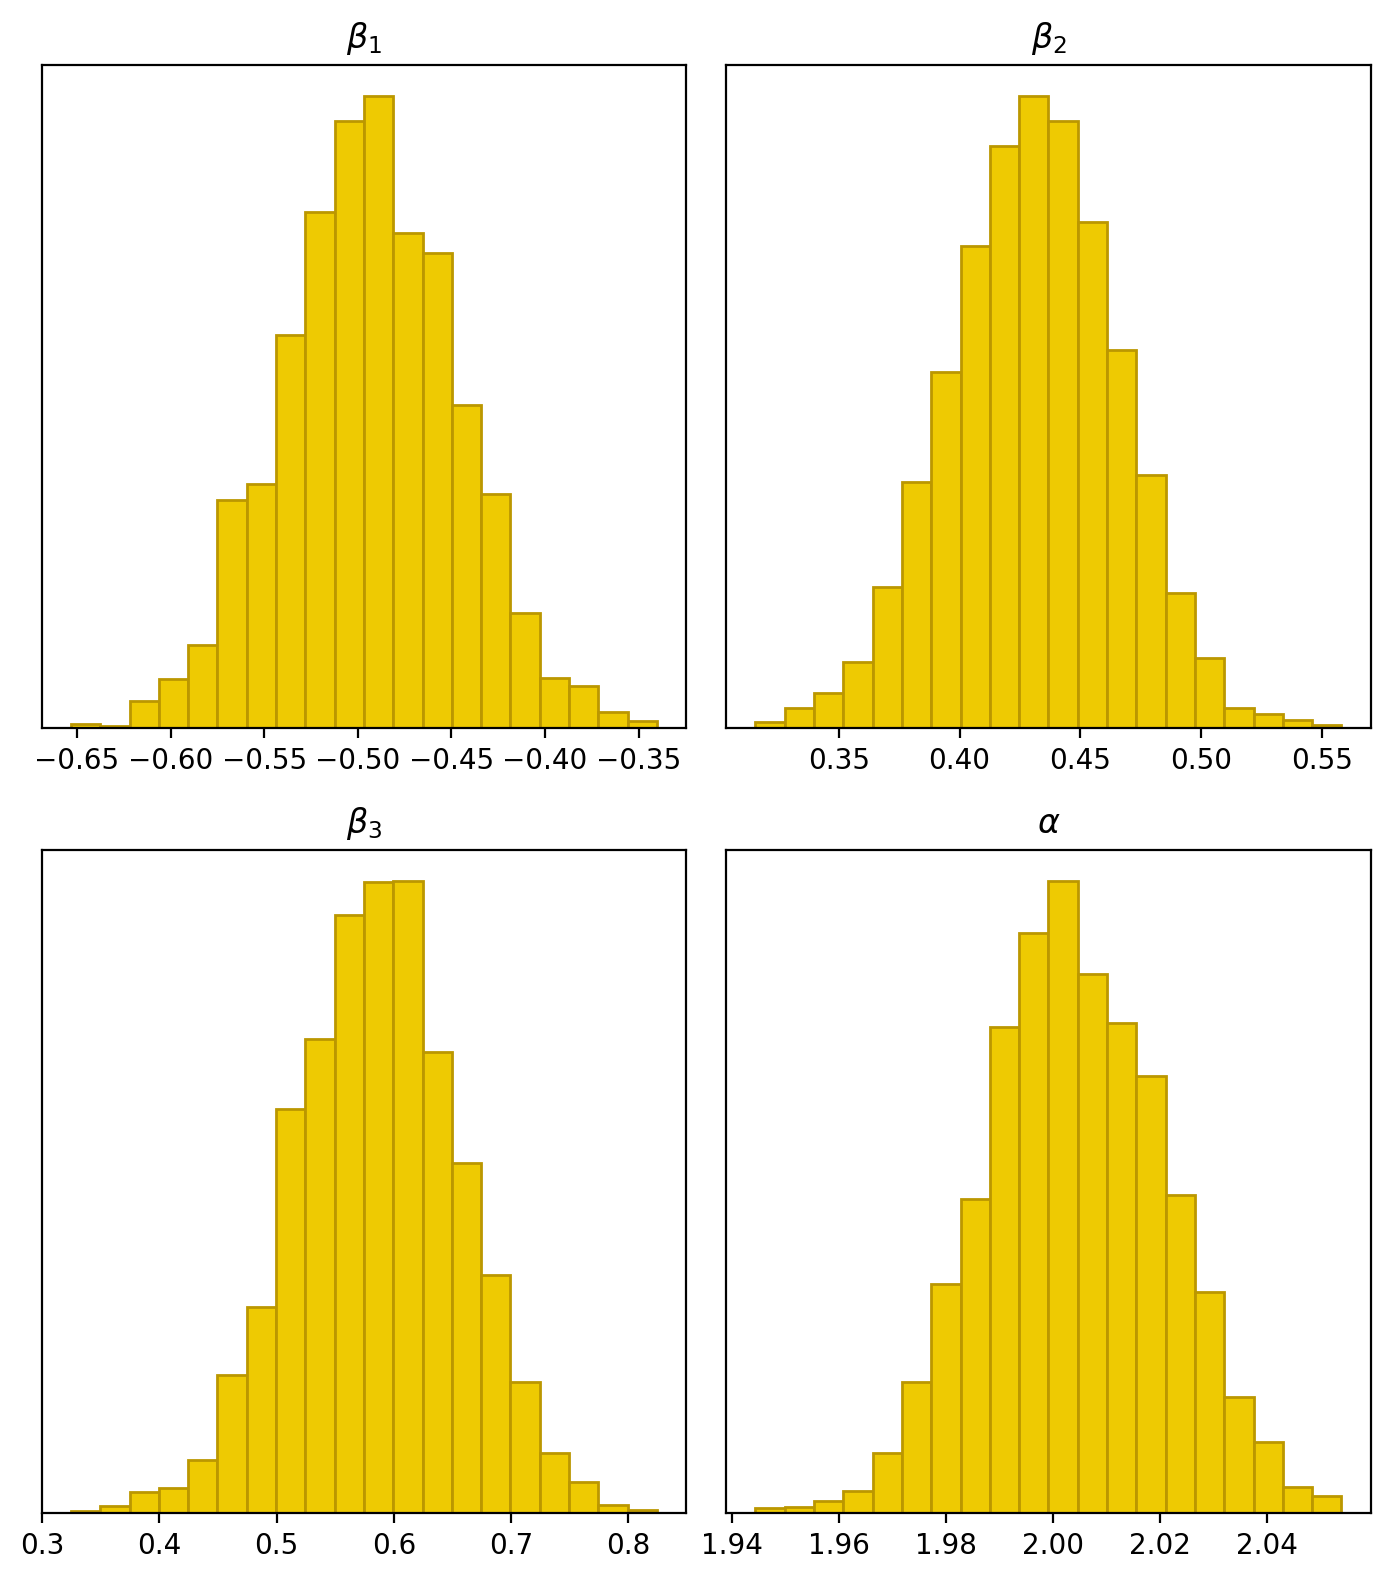

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(7, 8), squeeze=False)
axes_flat=axes.flatten()
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(pars_mat_1[:,k],bins=20,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
    ax.set_title(names_of_pars[k])
    ax.set_yticks([])
fig.tight_layout()

plt.show()

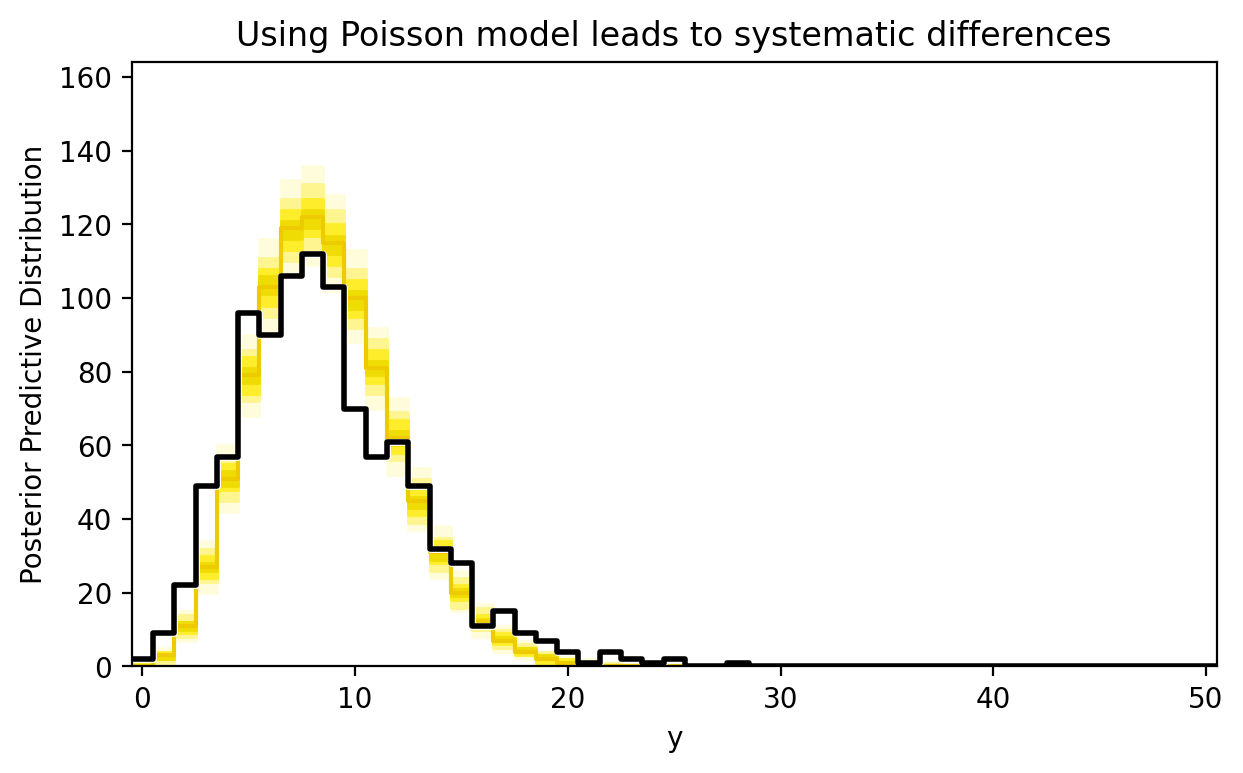

In [41]:
max_y = 50

y_prediction_1 = (fit.stan_variable('y_ppc'))

bins,counts = integer_histogram_matrix(max_y,y_prediction_1)
xs, pad_counts_pred = pad_hist_for_plot(bins,counts)    
#obs_counts = np.histogram(df['y'], bins=bins)[0]
#_, pad_obs_counts = pad_hist_for_plot(bins,obs_counts)


fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax=ribbon_plot(xs,pad_counts_pred,ax,supress_warning=True)

ax.plot(xs, pad_obs_counts, linewidth=2.5, color="white",zorder=1)
ax.plot(xs, pad_obs_counts, linewidth=2.0, color="black",zorder=2)

ax.set_xlim([min(bins), max(bins)])
ax.set_xlabel("y")
ax.set_ylim([0, max(max(obs_counts), np.max(counts))])
ax.set_ylabel("Posterior Predictive Distribution")
ax.set_title('Using Poisson model leads to systematic differences')


plt.show()

### Modelling dispersion in discrete regrssion

Negative binomial distribution in dispersion parametrization is equivalnent to concentration parametrization but with concentration parameter $\phi$ replaced with dispersion $\psi$,
$$
\psi = \frac{1}{\phi}.
$$

|Parameter Name|Symbol|Domain|Units|
|--- |--- |--- |--- |
|Intensity|$$\mu$$|$$\mathbb{R}^{+}$$|$$[x]$$|
|Dispersion|$$\psi$$|$$\mathbb{R}^{+}$$|$$[x^{-1}]$$|

This leads to following formulae:

|||
|--- |--- |
|Space|$$X = \mathbb{N}$$|
|Density|$$\pi(x; \mu, \psi) = {x + \psi^{-1} - 1 \choose x} \left( \frac{\mu \cdot \psi }{\mu \cdot \psi + 1} \right)^{x} \ \left( \frac{1}{\mu \cdot \psi + 1} \right)^{\frac{1}{\psi}}$$|
|Mean|$$\mu$$|
|Variance|$$\mu + \mu^{2} \cdot \psi$$|

This is advantageous, as when $\psi$ tends to zero, then Negaitve Binomial distribution tends to Poisson distribution.

For more details [see](https://betanalpha.github.io/assets/case_studies/probability_densities.html#36_the_negative_binomial_family_2:_electric_boogaloo).

In [43]:
model_nb = CmdStanModel(stan_file='negative_binomial.stan')
with open('negative_binomial.stan', 'r') as file:
    print(file.read())

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/j5/wr2j95x534x62nm4sfx97cbc0000gn/T/tmpxdxs7wn2/tmppuyprv8q
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 7 - Generalized linear models/Dispersed poisson regresion/negative_binomial
data {
  int<lower=0> M; // Number of covariates
  int<lower=0> N; // Number of observations
  matrix[N, M] X; // Covariate design matrix
  int y[N];      // Variates
}

parameters {
  vector[M] beta;        // Slopes
  real alpha;            // Intercept
  real<lower=0> inv_phi; // Over-dispersion parameter
}

transformed parameters {
  // Save phi
  real<lower=0> phi = 1 / inv_phi;
}

model {
  // Prior model
  beta ~ normal(0, 2);
  alpha ~ normal(0, 2);

  // inv_phi is more interpretable because inv_phi = 0
  // corresponds to the initial Poisson model
  inv_phi ~ exponential(1);

  // Observational model
  

In [67]:
fit = model_nb.sample(data=data, seed=4938483)

# Check diagnostics
fit.diagnose()


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:Processing csv files: /var/folders/j5/wr2j95x534x62nm4sfx97cbc0000gn/T/tmpiecmj9b_/negative_binomial-202105012208-1-wyq6_x1h.csv, /var/folders/j5/wr2j95x534x62nm4sfx97cbc0000gn/T/tmpiecmj9b_/negative_binomial-202105012208-2-riu5bnlg.csv, /var/folders/j5/wr2j95x534x62nm4sfx97cbc0000gn/T/tmpiecmj9b_/negative_binomial-202105012208-3-uynhv5or.csv, /var/folders/j5/wr2j95x534x62nm4sfx97cbc0000gn/T/tmpiecmj9b_/negative_binomial-202105012208-4-0qq8l27w.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfa

'Processing csv files: /var/folders/j5/wr2j95x534x62nm4sfx97cbc0000gn/T/tmpiecmj9b_/negative_binomial-202105012208-1-wyq6_x1h.csv, /var/folders/j5/wr2j95x534x62nm4sfx97cbc0000gn/T/tmpiecmj9b_/negative_binomial-202105012208-2-riu5bnlg.csv, /var/folders/j5/wr2j95x534x62nm4sfx97cbc0000gn/T/tmpiecmj9b_/negative_binomial-202105012208-3-uynhv5or.csv, /var/folders/j5/wr2j95x534x62nm4sfx97cbc0000gn/T/tmpiecmj9b_/negative_binomial-202105012208-4-0qq8l27w.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.'

In [52]:
pars_mat_nb = np.concatenate((fit.stan_variable('beta'),
                         np.expand_dims(fit.stan_variable('alpha'),axis=1), 
                         np.expand_dims(fit.stan_variable('phi'),axis=1),
                         np.expand_dims(fit.stan_variable('inv_phi'),axis=1)),
                        axis=1)

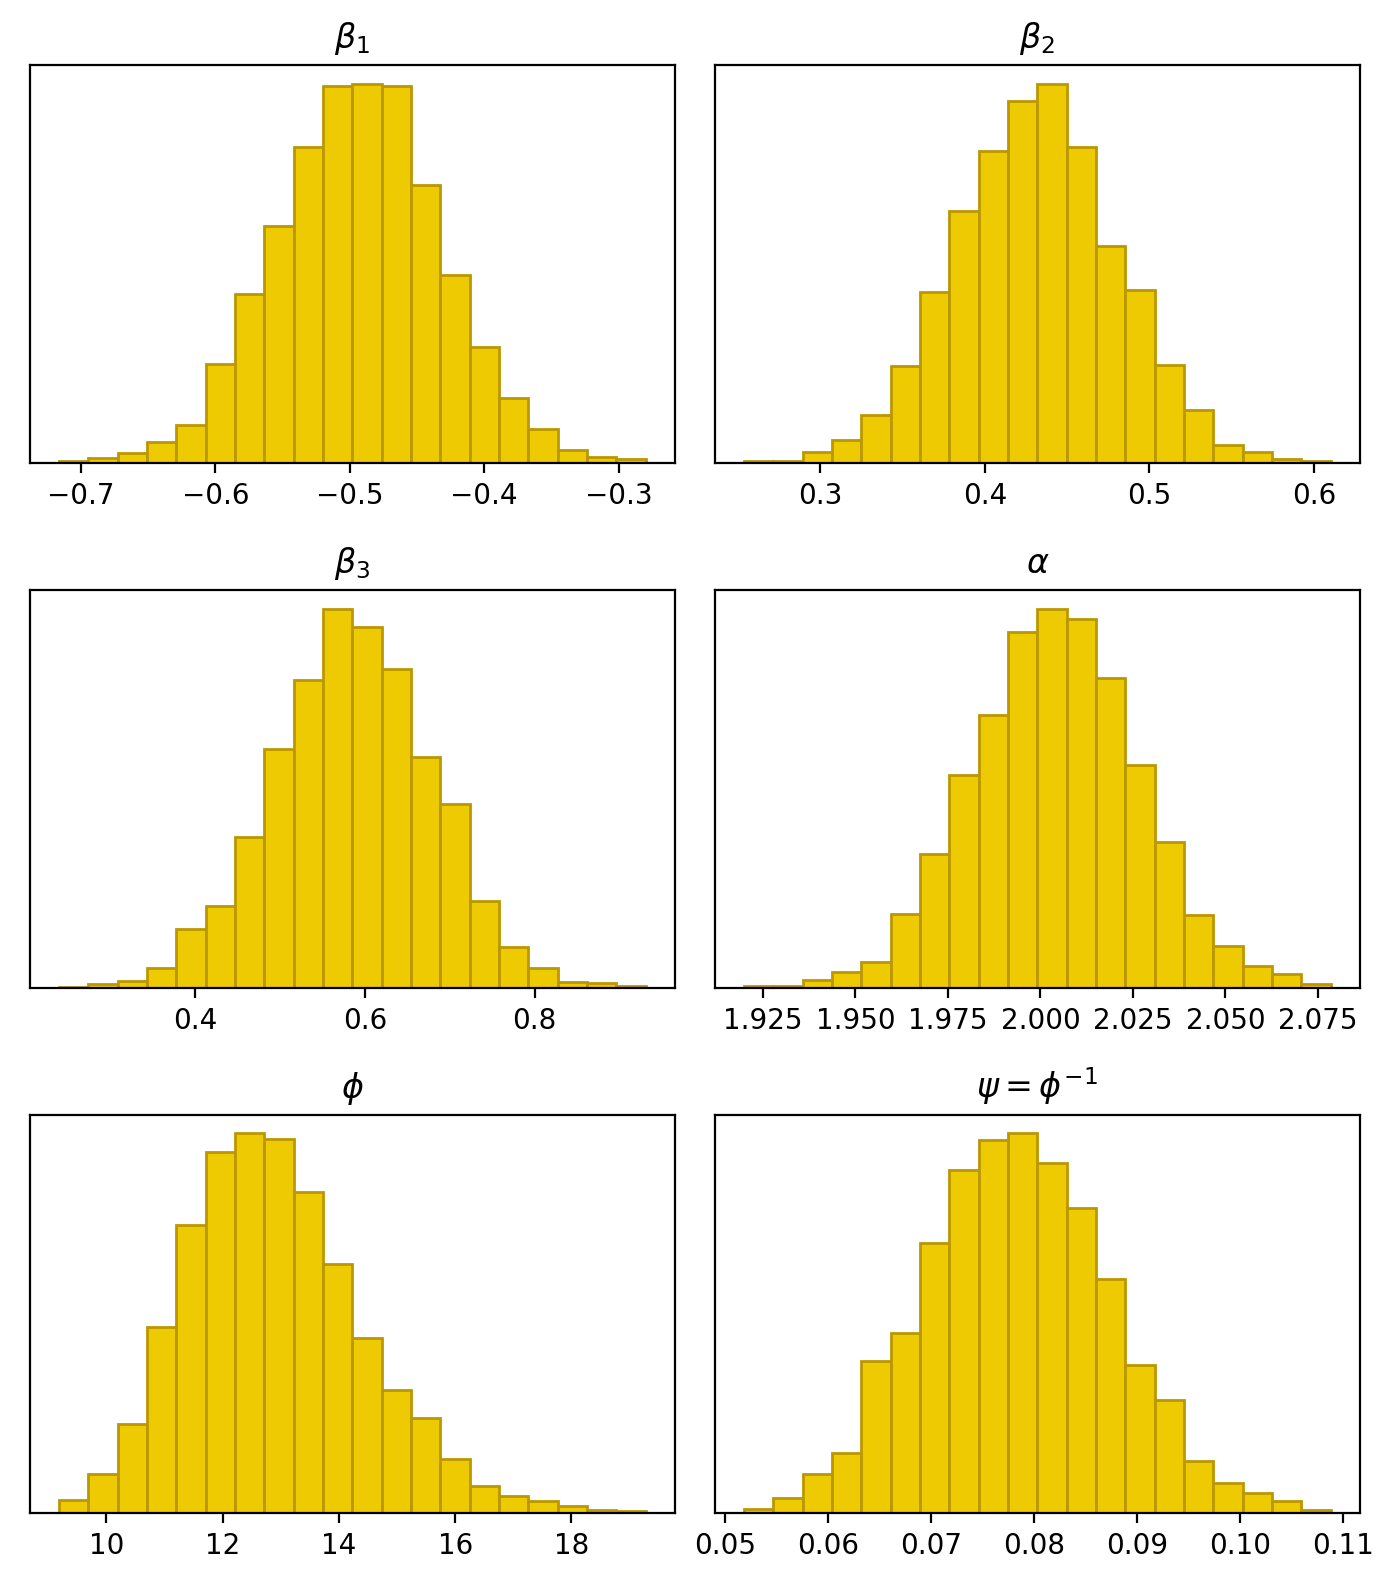

In [62]:
fig, axes = plt.subplots(3, 2, figsize=(7, 8), squeeze=False)
axes_flat=axes.flatten()
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(pars_mat_nb[:,k],bins=20,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
    ax.set_title(names_of_pars[k])
    ax.set_yticks([])
fig.tight_layout()

plt.show()

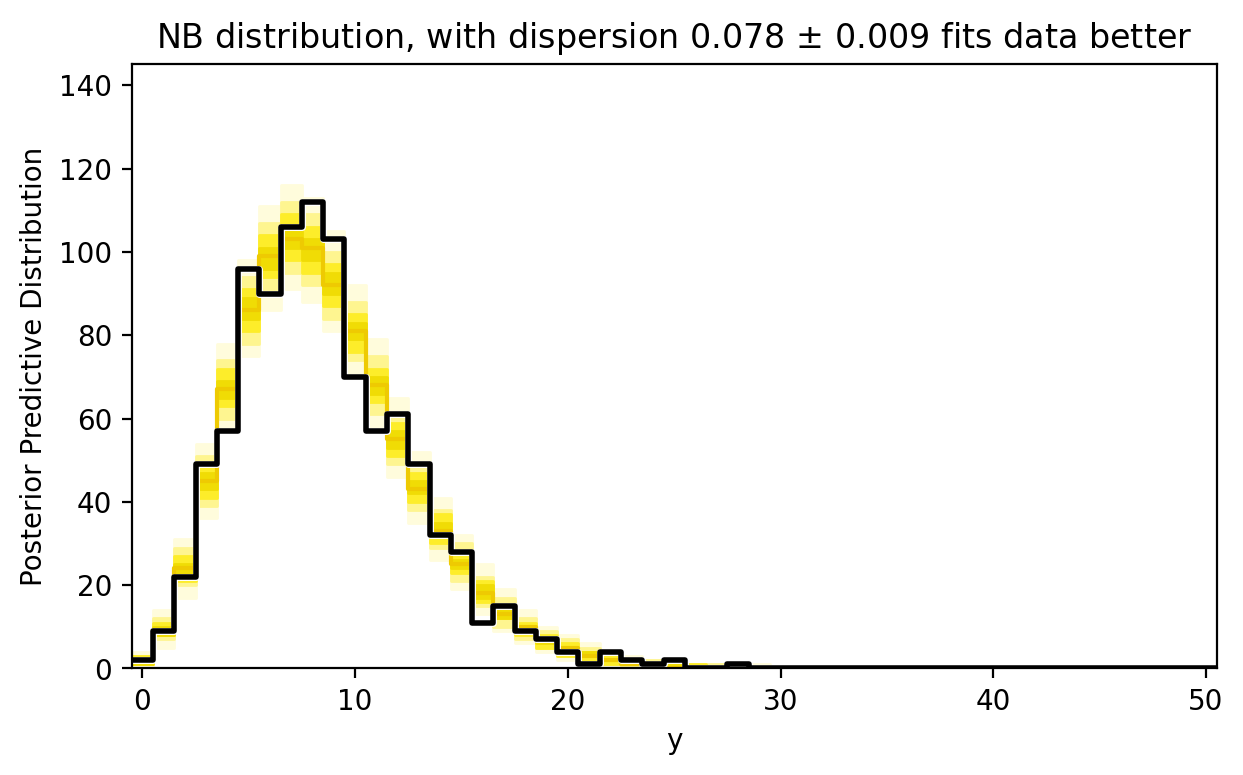

In [65]:
max_y = 50

y_prediction_2 = (fit.stan_variable('y_ppc'))

bins,counts = integer_histogram_matrix(max_y,y_prediction_2)
xs, pad_counts_pred_2 = pad_hist_for_plot(bins,counts)    
#obs_counts = np.histogram(df['y'], bins=bins)[0]
#_, pad_obs_counts = pad_hist_for_plot(bins,obs_counts)


fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax=ribbon_plot(xs,pad_counts_pred_2,ax,supress_warning=True)

ax.plot(xs, pad_obs_counts, linewidth=2.5, color="white",zorder=1)
ax.plot(xs, pad_obs_counts, linewidth=2.0, color="black",zorder=2)

ax.set_xlim([min(bins), max(bins)])
ax.set_xlabel("y")
ax.set_ylim([0, max(max(obs_counts), np.max(counts))])
ax.set_ylabel("Posterior Predictive Distribution")
m_psi=np.mean(fit.stan_variable('inv_phi'))
sd_psi=np.std(fit.stan_variable('inv_phi'))
ax.set_title('NB distribution, with dispersion {0:1.3f} $\pm$ {1:1.3f} fits data better'.format(m_psi,sd_psi))
plt.show()

